In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# https://datahack.analyticsvidhya.com/contest/mckinsey-analytics-online-hackathon-4/#

## TODO: implement bootstrapping for getting coefficient error bars
## TODO: implement proper data transformation pipelining
## TODO: normalize/scale inputs to allow for use of regularization

file = "train_ZoGVYWq.csv"
data = pd.read_csv(file)

def pre_prep(df):
    data = df.copy()
    data.set_index('id', inplace=True)
    data['renewal'] = data['renewal'].astype('bool')
    data['sourcing_channel'] = data['sourcing_channel'].astype('category') 
    data['residence_area_type'] = data['residence_area_type'].astype('category')
    new_names = {'perc_premium_paid_by_cash_credit': 'cash_credit',
                'Count_3-6_months_late': 'late3',
                'Count_6-12_months_late': 'late6',
                'Count_more_than_12_months_late': 'late12',
                'application_underwriting_score': 'score',
                'residence_area_type': 'residence',
                'no_of_premiums_paid': 'prems_paid',
                'sourcing_channel': 'channel'}
    data.rename(index=str, columns=new_names, inplace=True)
    return data

data_pre_prepped = pre_prep(data)

In [2]:
data_pre_prepped.T

id,110936,41492,31300,19415,99379,59951,54031,94290,93730,84844,...,84628,11262,25366,104705,91081,48057,59012,77050,67225,71531
cash_credit,0.429,0.01,0.917,0.049,0.052,0.54,1,1,0.621,0.908,...,0.454,0.994,0.825,0.118,0.033,0.425,0.704,0,0.398,0.55
age_in_days,12058,21546,17531,15341,31400,17527,24829,21911,9868,23008,...,25928,20445,14979,22275,18265,23367,19356,23372,22641,15709
Income,355060,315150,84140,250510,198680,282080,118400,180240,92520,107180,...,70800,186830,360060,195070,301540,224550,279150,305020,39330,280140
late3,0,0,2,0,0,2,0,1,0,2,...,0,0,2,0,0,1,1,0,0,1
late6,0,0,3,0,0,0,0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
late12,0,0,1,0,0,0,0,4,0,0,...,0,0,0,0,0,0,1,0,0,1
score,99.02,99.89,98.69,99.57,99.87,99.18,99.05,99.33,99.58,98.91,...,98.19,99.67,98.61,99.25,99.89,98.7,99.42,98.89,98.68,99.84
prems_paid,13,21,7,9,12,9,11,3,4,11,...,7,5,10,11,4,19,12,12,8,8
channel,C,A,C,A,B,B,B,A,A,A,...,A,A,D,A,A,B,A,A,A,A
residence,Urban,Urban,Rural,Urban,Urban,Rural,Urban,Urban,Urban,Rural,...,Urban,Urban,Urban,Urban,Rural,Urban,Rural,Rural,Rural,Urban


## Split sets

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_pre_prepped.drop('renewal', axis=1), 
                                                    data_pre_prepped['renewal'], 
                                                    test_size=0.20, 
                                                    random_state=42)

# train_test_split(data_pre_prepped, data_pre_prepped['renewal'], test_size=0.20, random_state=42)
len(X_train)

63882

In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63882 entries, 56158 to 99690
Data columns (total 11 columns):
cash_credit    63882 non-null float64
age_in_days    63882 non-null int64
Income         63882 non-null int64
late3          63801 non-null float64
late6          63801 non-null float64
late12         63801 non-null float64
score          61534 non-null float64
prems_paid     63882 non-null int64
channel        63882 non-null category
residence      63882 non-null category
premium        63882 non-null int64
dtypes: category(2), float64(5), int64(4)
memory usage: 5.0+ MB


 # Creating the transformation pipeline
 ## Imputation
 

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from dftrans.dftrans import DFFeatureUnion

In [30]:
X_train.T

id,56158,83192,22201,104286,43583,32448,102249,103508,8479,2787,...,70075,44043,27304,49918,73496,54749,68207,74635,62208,99690
cash_credit,0.527,0.901,0.262,0.868,0.186,0.023,0,0.188,0.938,0.319,...,0.024,0.339,0.694,0.703,0.047,0.281,0.408,0.066,0.42,0
age_in_days,14248,18265,28844,22642,18625,24099,18629,24105,13515,16439,...,25194,9136,18258,13154,22645,11689,14610,18265,12420,14608
Income,242270,203390,92140,137620,249030,134050,223620,171100,272310,143920,...,129150,27050,243060,225140,150050,187640,202280,270040,122610,102030
late3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
late6,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
late12,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
score,99.31,99.25,99.11,98.85,99.45,99.76,99.25,98.77,99.28,98.68,...,98.92,99.85,99.48,98.25,99.03,98.48,98.45,98.9,98.91,99.22
prems_paid,8,8,10,17,8,8,9,18,8,11,...,18,5,7,11,10,10,19,12,11,6
channel,E,B,A,D,A,A,B,A,C,A,...,C,A,C,C,B,A,A,A,C,A
residence,Rural,Urban,Urban,Urban,Rural,Rural,Rural,Urban,Urban,Urban,...,Urban,Rural,Rural,Urban,Urban,Urban,Urban,Urban,Rural,Urban


In [33]:
le = LabelEncoder()
ohe = OneHotEncoder(sparse=False)
name = 'channel'
X_train['channel_le'] = le.fit_transform(X_train[name])
X_train[] = ohe.fit_transform(X_train[['channel_le']])
print(out2)

[[0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [35]:
le.classes_

array(['A', 'B', 'C', 'D', 'E'], dtype=object)

In [6]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
X_train[['score', 'late3', 'late6', 'late12']] = imp.fit_transform(X_train[['score', 'late3', 'late6', 'late12']])

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63882 entries, 56158 to 99690
Data columns (total 11 columns):
cash_credit    63882 non-null float64
age_in_days    63882 non-null int64
Income         63882 non-null int64
late3          63882 non-null float64
late6          63882 non-null float64
late12         63882 non-null float64
score          63882 non-null float64
prems_paid     63882 non-null int64
channel        63882 non-null category
residence      63882 non-null category
premium        63882 non-null int64
dtypes: category(2), float64(5), int64(4)
memory usage: 5.0+ MB


In [8]:
X_train.head()

,cash_credit,age_in_days,Income,late3,late6,late12,score,prems_paid,channel,residence,premium
id,,,,,,,,,,,
56158,0.527,14248,242270,0.0,0.0,0.0,99.31,8,E,Rural,1200
83192,0.901,18265,203390,0.0,0.0,0.0,99.25,8,B,Urban,9600
22201,0.262,28844,92140,0.0,0.0,0.0,99.11,10,A,Urban,5400
104286,0.868,22642,137620,1.0,0.0,0.0,98.85,17,D,Urban,11700
43583,0.186,18625,249030,0.0,0.0,0.0,99.45,8,A,Rural,20100


## Categorical transformation

In [9]:
def create_dummies(df):
    df_new = pd.get_dummies(data=df.copy(), prefix='channel', columns=['channel'], drop_first=True)
    df_new = pd.get_dummies(data=df_new, prefix='residence', columns=['residence'], drop_first=True)
    return df_new


X_train = create_dummies(X_train)

## Transform features numerically

In [10]:
from sklearn.preprocessing import Binarizer

In [11]:
#biner = Binarizer(threshold=.7)
#X_train[['cash_credit']] = biner.fit_transform(X_train[['cash_credit']])

In [12]:
from sklearn.preprocessing import FunctionTransformer, QuantileTransformer, StandardScaler

scaler = StandardScaler()
X_train[['age_in_days']] = scaler.fit_transform(X_train[['age_in_days']])

log_trans = FunctionTransformer(np.log1p)
X_train[['Income']] = log_trans.transform(X_train[['Income']])
# X_train[['late3']] = log_trans.transform(X_train[['late3']])
# X_train[['late6']] = log_trans.transform(X_train[['late6']])
# X_train[['late12']] = log_trans.transform(X_train[['late12']])

prem_trans = FunctionTransformer(lambda x : np.power(x, 1))
X_train[['premium']] = prem_trans.transform(X_train[['premium']])
scaler_prems = StandardScaler()
X_train[['premium']] = scaler_prems.fit_transform(X_train[['premium']])

# qt = QuantileTransformer(n_quantiles=10, random_state=0)
# X_train[['premium']] = qt.fit_transform(X_train[['premium']])

exp_trans = FunctionTransformer(lambda x: np.exp(x/100))
X_train[['score']] = exp_trans.transform(X_train[['score']])

In [13]:
X_train.to_csv("train_imputed_encoded.csv")
X_train.describe()

,cash_credit,age_in_days,Income,late3,late6,late12,score,prems_paid,premium,channel_B,channel_C,channel_D,channel_E,residence_Urban
count,63882.000000,6.388200e+04,63882.000000,63882.000000,63882.000000,63882.000000,63882.000000,63882.000000,6.388200e+04,63882.000000,63882.000000,63882.000000,63882.000000,63882.000000
mean,0.313499,-2.122218e-16,12.002447,0.245357,0.077804,0.059184,2.693148,10.851946,-8.764717e-17,0.206020,0.150481,0.094048,0.007295,0.605491
std,0.334326,1.000008e+00,0.661145,0.685053,0.433123,0.309787,0.019369,5.155890,1.000008e+00,0.404449,0.357545,0.291898,0.085098,0.488749
min,0.000000,-2.146756e+00,10.087100,0.000000,0.000000,0.000000,2.508287,2.000000,-1.035460e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.034000,-7.432534e-01,11.590104,0.000000,0.000000,0.000000,2.686932,7.000000,-5.878761e-01,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.166000,-4.169416e-02,12.021434,0.000000,0.000000,0.000000,2.696353,10.000000,-3.640842e-01,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.536000,7.290410e-01,12.435560,0.000000,0.000000,0.000000,2.705265,14.000000,3.072913e-01,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,3.604838e+00,18.318234,13.000000,17.000000,11.000000,2.715293,60.000000,5.230712e+00,1.000000,1.000000,1.000000,1.000000,1.000000


# Train LogReg Model

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [15]:
m = XGBClassifier()

In [16]:
m.fit(X=X_train, y=y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [17]:
#m.coef_[0]

In [18]:
#coeffs = dict(zip(X_train.columns, m.coef_[0]))
#from pprint import pprint
# pprint(coeffs)
#plt.bar(range(len(coeffs)), list(coeffs.values()), align='center')
#plt.xticks(range(len(coeffs)), list(coeffs.keys()), rotation=90)

#plt.show()

In [19]:
X_train.head()

,cash_credit,age_in_days,Income,late3,late6,late12,score,prems_paid,premium,channel_B,channel_C,channel_D,channel_E,residence_Urban
id,,,,,,,,,,,,,,
56158,0.527,-0.882758,12.397812,0.0,0.0,0.0,2.699590,8,-1.035460,0,0,0,1,0
83192,0.901,-0.110870,12.222886,0.0,0.0,0.0,2.697971,8,-0.140292,1,0,0,0,1
22201,0.262,1.921942,11.431075,0.0,0.0,0.0,2.694196,10,-0.587876,0,0,0,0,1
104286,0.868,0.730194,11.832259,1.0,0.0,0.0,2.687201,17,0.083499,0,0,1,0,1
43583,0.186,-0.041694,12.425333,0.0,0.0,0.0,2.703372,8,0.978667,0,0,0,0,0


## Prep model test input

In [20]:
X_test = create_dummies(X_test)

sum(X_test.isnull().any(axis=1))

628

In [21]:
def trans(X_test):
    X_test_trans = X_test.copy()
    X_test_trans[['score', 'late3', 'late6', 'late12']] = imp.transform(X_test_trans[['score', 'late3', 'late6', 'late12']])
    #X_test_trans[['cash_credit']] = biner.transform(X_test_trans[['cash_credit']])
    X_test_trans[['Income']] = log_trans.transform(X_test_trans[['Income']])
    # X_test_trans[['late3']] = log_trans.transform(X_test_trans[['late3']])
    # X_test_trans[['late6']] = log_trans.transform(X_test_trans[['late6']])
    # X_test_trans[['late12']] = log_trans.transform(X_test_trans[['late12']])
    X_test_trans[['score']] = exp_trans.transform(X_test_trans[['score']])
    X_test_trans[['premium']] = prem_trans.transform(X_test_trans[['premium']])
    X_test_trans[['premium']] = scaler_prems.fit_transform(X_test_trans[['premium']])

    X_test_trans[['age_in_days']] = scaler.transform(X_test_trans[['age_in_days']])
    return X_test_trans

X_test_trans = trans(X_test)

assert sum(X_test_trans.isnull().any(axis=1))==0

In [22]:
y_proba = m.predict_proba(X_test_trans)[:,1]

## Analysis

In [23]:
print(classification_report(y_true=y_test, y_pred=y_proba>.9))

             precision    recall  f1-score   support

      False       0.27      0.63      0.38      1032
       True       0.97      0.88      0.92     14939

avg / total       0.93      0.87      0.89     15971



In [24]:
#plt.hist(y_proba, bins='auto')

In [25]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba, pos_label=True)
roc_auc = metrics.roc_auc_score(y_test, y_proba)

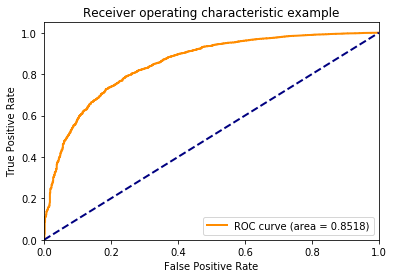

In [26]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Using on test data

In [26]:
data_test = pd.read_csv("test_66516Ee.csv")

def pre_prep(df):
    data = df.copy()
    data.set_index('id', inplace=True)
    data['sourcing_channel'] = data['sourcing_channel'].astype('category') 
    data['residence_area_type'] = data['residence_area_type'].astype('category')
    new_names = {'perc_premium_paid_by_cash_credit': 'cash_credit',
                'Count_3-6_months_late': 'late3',
                'Count_6-12_months_late': 'late6',
                'Count_more_than_12_months_late': 'late12',
                'application_underwriting_score': 'score',
                'residence_area_type': 'residence',
                'no_of_premiums_paid': 'prems_paid',
                'sourcing_channel': 'channel'}
    data.rename(index=str, columns=new_names, inplace=True)
    return data

data_pre_prepped_test = pre_prep(data_test)

In [27]:
test = create_dummies(data_pre_prepped_test)
test = trans(test)

In [28]:
test.head()

,cash_credit,age_in_days,Income,late3,late6,late12,score,prems_paid,premium,channel_B,channel_C,channel_D,channel_E,residence_Urban
id,,,,,,,,,,,,,,
649,0.001,1.641395,10.842537,0.0,0.0,0.0,2.715293,7,-0.813427,0,0,0,0,0
81136,0.124,0.940220,12.560739,0.0,0.0,0.0,2.689351,19,0.093413,0,0,0,0,1
70762,1.000,-0.321280,12.133669,0.0,0.0,0.0,2.693077,2,0.093413,1,0,0,0,1
53935,0.198,-0.533035,11.724328,0.0,0.0,0.0,2.691234,11,-0.586717,1,0,0,0,0
15476,0.041,-1.585470,12.206178,1.0,0.0,0.0,2.695813,14,-0.133297,0,0,0,0,0


In [29]:
X_test_trans.head()

,cash_credit,age_in_days,Income,late3,late6,late12,score,prems_paid,premium,channel_B,channel_C,channel_D,channel_E,residence_Urban
id,,,,,,,,,,,,,,
67251,0.125,-0.392954,12.104101,0.0,0.0,0.0,2.687469,15,0.300157,0,0,1,0,1
86418,0.021,0.871044,12.032380,0.0,0.0,0.0,2.696353,20,-0.364906,1,0,0,0,1
101134,0.033,0.589152,11.538116,0.0,0.0,0.0,2.674600,7,-0.364906,0,0,0,0,1
55058,0.147,-1.024569,12.507809,0.0,0.0,0.0,2.698780,7,1.408593,0,1,0,0,1
2632,1.000,-1.513604,10.842146,0.0,0.0,0.0,2.712579,3,-0.808280,0,0,0,0,1


In [30]:
y_proba = m.predict_proba(test)[:,1]

In [31]:
out = pd.DataFrame({'id': data_pre_prepped_test.index, 'renewal': y_proba, 'incentives': 200 * np.ones(len(y_proba))})
out.head()

,id,renewal,incentives
0,649,0.986124,200.0
1,81136,0.979425,200.0
2,70762,0.921332,200.0
3,53935,0.969518,200.0
4,15476,0.959812,200.0


In [32]:
out.to_csv('pred.csv', index=False)